In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import polars as pl
import glob
import re
import ast
from pathlib import Path
import numpy as np
from scipy.optimize import curve_fit

In [3]:
def procesar_y_expandir_logs(ruta_busqueda: str) -> pl.DataFrame:
    """
    Busca archivos de log, extrae información relevante y expande los
    hiperparámetros en columnas separadas dentro de un DataFrame de Polars.

    Args:
        ruta_busqueda (str): Patrón de búsqueda para glob (ej. 'logs/*.out').
    """
    lista_archivos = glob.glob(ruta_busqueda)

    if not lista_archivos:
        print(f"No se encontraron archivos con el patrón '{ruta_busqueda}'.")
        return pl.DataFrame()

    datos_extraidos = []

    # Expresiones regulares ajustadas
    regex = {
        'n_jobs': re.compile(r"N_JOBS=(\d+)"),
        'n_samples': re.compile(r"N_SAMPLES=(\d+)"),
        'slurm_cpus_per_task': re.compile(r"SLURM_CPUS_PER_TASK=(\d+)"),
        'inner_n_jobs': re.compile(r"inner_n_jobs=(\d+)"),
        'tiempo_total': re.compile(r"TIEMPO TOTAL ENTRENAMIENTO \(pared\): ([\d\.]+) s"),
        # --- REGEX MEJORADA: Busca específicamente un string que empieza con { y termina con } ---
        'params': re.compile(r"params=(\{.*\})")
    }

    print(f"Procesando {len(lista_archivos)} archivo(s)...")

    for archivo_path in lista_archivos:
        path_obj = Path(archivo_path)
        with open(path_obj, 'r', encoding='utf-8') as f:
            contenido = f.read()

            # Diccionario base para esta fila de datos
            fila_datos = {
                'archivo': path_obj.name
            }

            # Extraer los datos básicos
            n_jobs = re.search(regex['n_jobs'], contenido)
            fila_datos['n_jobs'] = int(n_jobs.group(1)) if n_jobs else None

            n_samples = re.search(regex['n_samples'], contenido)
            fila_datos['n_samples'] = int(n_samples.group(1)) if n_samples else None

            slurm_cpus = re.search(regex['slurm_cpus_per_task'], contenido)
            fila_datos['slurm_cpus_per_task'] = int(slurm_cpus.group(1)) if slurm_cpus else None

            inner_n_jobs = re.search(regex['inner_n_jobs'], contenido)
            fila_datos['inner_n_jobs'] = int(inner_n_jobs.group(1)) if inner_n_jobs else None

            tiempo = re.search(regex['tiempo_total'], contenido)
            fila_datos['tiempo_total_entrenamiento'] = float(tiempo.group(1)) if tiempo else None

            # --- LÓGICA MEJORADA PARA PARSEAR Y EXPANDIR PARÁMETROS ---
            params_match = re.search(regex['params'], contenido)
            if params_match:
                # Obtenemos el string del diccionario capturado por el grupo 1
                params_string_limpio = params_match.group(1).strip()
                try:
                    # Parseamos el string a un diccionario de Python
                    params_dict = ast.literal_eval(params_string_limpio)
                    # Actualizamos el diccionario de la fila con los parámetros
                    fila_datos.update(params_dict)
                except (ValueError, SyntaxError):
                    print(f"Advertencia: No se pudieron parsear los parámetros en el archivo {path_obj.name}")
                    # Para depuración, imprime el string que falló
                    print(f"   ---> String problemático: '{params_string_limpio}'")

            datos_extraidos.append(fila_datos)

    # Polars creará automáticamente las columnas para todas las claves encontradas,
    # rellenando con 'null' los valores faltantes en cada fila.
    if not datos_extraidos:
        return pl.DataFrame()

    df = pl.DataFrame(datos_extraidos)
    return df

In [4]:
base_path = Path('logs')
file_glob = 'rnn_rnn_joblib_*.out'
df_resultados = procesar_y_expandir_logs(ruta_busqueda=base_path.joinpath(file_glob).as_posix())

Procesando 116 archivo(s)...


In [5]:
df_resultados

archivo,n_jobs,n_samples,slurm_cpus_per_task,inner_n_jobs,tiempo_total_entrenamiento,mlpclassifier__alpha,mlpclassifier__hidden_layer_sizes,mlpclassifier__learning_rate_init
str,i64,i64,i64,i64,f64,f64,list[i64],f64
"""rnn_rnn_joblib_14794_0.out""",1,5000,32,1,53.157,0.0001,[64],0.001
"""rnn_rnn_joblib_14794_1.out""",2,5000,32,1,28.888,0.0001,[64],0.001
"""rnn_rnn_joblib_14794_10.out""",16,10000,32,1,10.855,0.0001,[64],0.001
"""rnn_rnn_joblib_14794_11.out""",32,10000,32,1,10.831,0.0001,[64],0.001
"""rnn_rnn_joblib_14794_12.out""",1,20000,32,1,193.788,0.0001,[64],0.001
…,…,…,…,…,…,…,…,…
"""rnn_rnn_joblib_ex5_16511_7.out""",2,10000,32,1,166.152,0.0001,[256],0.001
"""rnn_rnn_joblib_ex5_16511_70.ou…",16,40000,32,1,229.575,0.0001,[256],0.001
"""rnn_rnn_joblib_ex5_16511_71.ou…",32,40000,32,1,231.243,0.0001,[256],0.001


In [6]:
df_resultados_measures = df_resultados.with_columns(
    pl.col('tiempo_total_entrenamiento').filter(pl.col('n_jobs') == 1).first().over('n_samples').alias(
        'numerador_speedup')).with_columns(
    speedup=pl.col('numerador_speedup') / pl.col('tiempo_total_entrenamiento')).with_columns(
    efficiency=pl.col('speedup') / pl.col('n_jobs'),speedup_pct_change=pl.col('speedup').pct_change().over('n_samples',order_by='n_jobs')).sort(by=['n_samples','n_jobs'])

In [7]:
df_resultados_measures

archivo,n_jobs,n_samples,slurm_cpus_per_task,inner_n_jobs,tiempo_total_entrenamiento,mlpclassifier__alpha,mlpclassifier__hidden_layer_sizes,mlpclassifier__learning_rate_init,numerador_speedup,speedup,efficiency,speedup_pct_change
str,i64,i64,i64,i64,f64,f64,list[i64],f64,f64,f64,f64,f64
"""rnn_rnn_joblib_ex5_16511_48.ou…",1,5000,32,1,229.938,0.0001,[256],0.001,53.157,0.23118,0.23118,-0.187598
"""rnn_rnn_joblib_ex5_16511_24.ou…",1,5000,32,1,186.802,0.0001,[256],0.001,53.157,0.284563,0.284563,-0.097938
"""rnn_rnn_joblib_14794_0.out""",1,5000,32,1,53.157,0.0001,[64],0.001,53.157,1.0,1.0,null
"""rnn_rnn_joblib_ex5_16511_0.out""",1,5000,32,1,168.507,0.0001,[256],0.001,53.157,0.315459,0.315459,-0.024753
"""rnn_rnn_joblib_ex5_16433_0.out""",1,5000,32,1,164.336,0.0001,[256],0.001,53.157,0.323465,0.323465,-0.676535
…,…,…,…,…,…,…,…,…,…,…,…,…
"""rnn_rnn_joblib_ex5_16511_46.ou…",16,40000,32,1,180.754,0.0001,[256],0.001,380.896,2.107262,0.131704,-0.157673
"""rnn_rnn_joblib_ex5_16511_23.ou…",32,40000,32,1,152.086,0.0001,[256],0.001,380.896,2.504478,0.078265,-0.750115
"""rnn_rnn_joblib_14799_5.out""",32,40000,32,1,38.004,0.0001,[64],0.001,380.896,10.022524,0.313204,5.040811


In [ ]:
df_grafico=df_resultados_measures

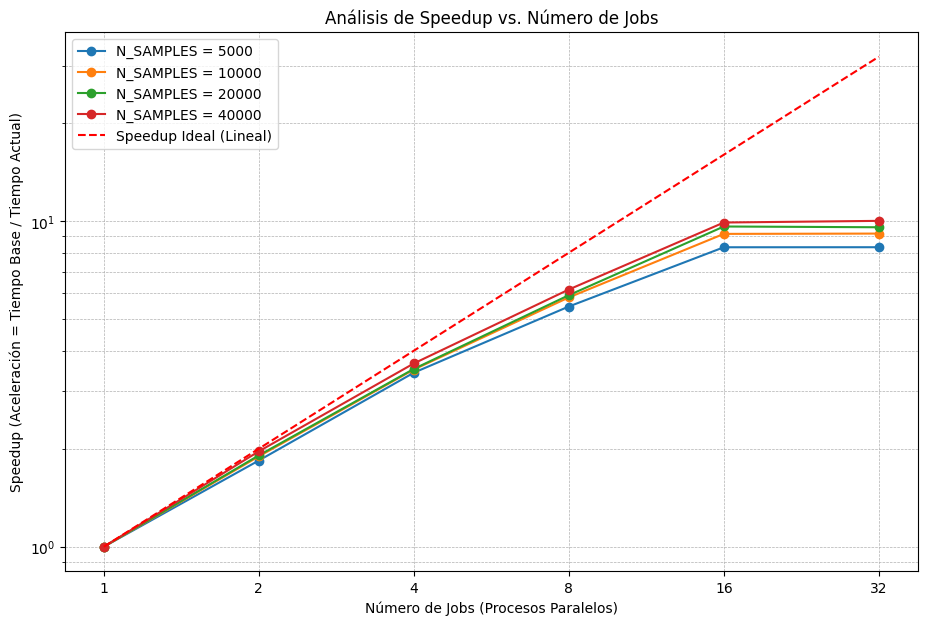

In [8]:
plt.figure(figsize=(11, 7))

# 3. Obtenemos los valores únicos de n_samples para crear una línea por cada uno
valores_n_samples = df_grafico.get_column("n_samples").unique().sort()

# 4. Iteramos sobre cada valor de n_samples y ploteamos su línea
for n_samp in valores_n_samples:
    # Filtramos el DataFrame para obtener solo los datos de este n_samples
    subset = df_grafico.filter(pl.col("n_samples") == n_samp)

    plt.plot(
        subset.get_column("n_jobs"),       # Eje X
        subset.get_column("speedup"),      # Eje Y
        marker='o',                        # Poner un círculo en cada punto de dato
        linestyle='-',                     # Unir los puntos con una línea
        label=f'N_SAMPLES = {n_samp}'    # Etiqueta para la leyenda
    )

# --- ESTILIZACIÓN DE LA GRÁFICA (adaptado de tu ejemplo) ---

# 5. Añadimos una línea de "Speedup Ideal" para comparar
# El speedup ideal es lineal (si duplicas los procesadores, duplicas la velocidad)
todos_los_n_jobs = df_grafico.get_column("n_jobs").unique().sort()
plt.plot(
    todos_los_n_jobs,
    todos_los_n_jobs,
    linestyle='--',
    color='red',
    label='Speedup Ideal (Lineal)'
)

# 6. Configuramos etiquetas y título
plt.xlabel("Número de Jobs (Procesos Paralelos)")
plt.ylabel("Speedup (Aceleración = Tiempo Base / Tiempo Actual)")
plt.title("Análisis de Speedup vs. Número de Jobs")

# 7. Configuramos el eje X en escala logarítmica base 2
# Esto es ideal cuando tus jobs son potencias de 2 (1, 2, 4, 8...)
plt.xscale("log", base=2)
plt.yscale("log")
plt.xticks(todos_los_n_jobs, todos_los_n_jobs) # Mostramos los ticks en el eje X

# 8. Añadimos leyenda y cuadrícula
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)

# 9. Mostramos la gráfica
plt.show()

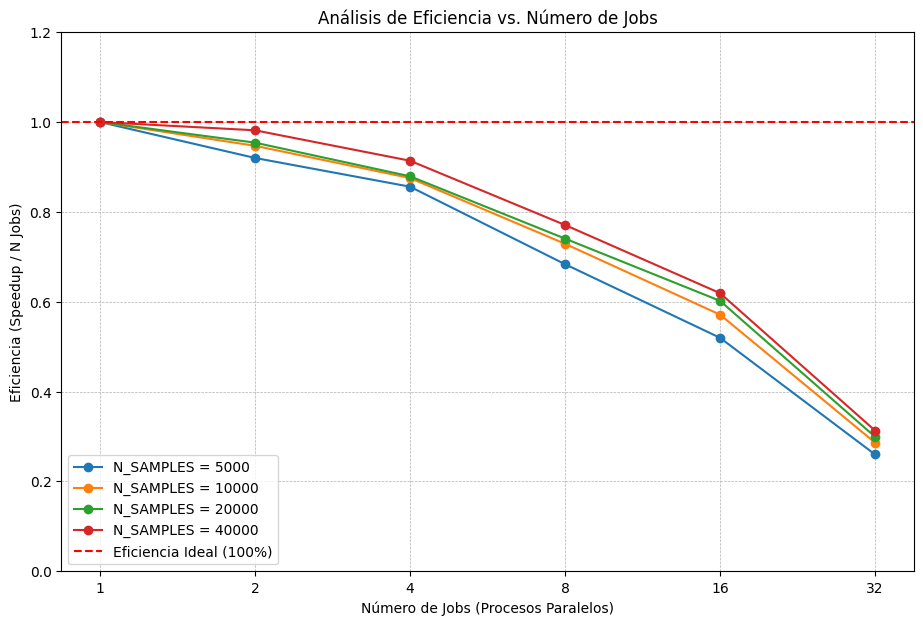

In [9]:
plt.figure(figsize=(11, 7))

# 3. Obtenemos los valores únicos de n_samples
valores_n_samples = df_grafico.get_column("n_samples").unique().sort()

# 4. Iteramos sobre cada valor y ploteamos su línea
for n_samp in valores_n_samples:
    subset = df_grafico.filter(pl.col("n_samples") == n_samp)

    plt.plot(
        subset.get_column("n_jobs"),
        subset.get_column("efficiency"),  # <-- CAMBIO AQUÍ
        marker='o',
        linestyle='-',
        label=f'N_SAMPLES = {n_samp}'
    )

# --- ESTILIZACIÓN DE LA GRÁFICA ---

# 5. Añadimos una línea de "Eficiencia Ideal" (un valor constante de 1.0)
plt.axhline(y=1.0, linestyle='--', color='red', label='Eficiencia Ideal (100%)')

# 6. Configuramos etiquetas y título
plt.xlabel("Número de Jobs (Procesos Paralelos)")
plt.ylabel("Eficiencia (Speedup / N Jobs)")
plt.title("Análisis de Eficiencia vs. Número de Jobs")

# 7. Configuramos el eje X en escala logarítmica base 2
todos_los_n_jobs = df_grafico.get_column("n_jobs").unique().sort()
plt.xscale("log", base=2)
plt.xticks(todos_los_n_jobs, todos_los_n_jobs)

# Opcional: ajustar los límites del eje Y para enfocarse entre 0 y 1.2
plt.ylim(0, 1.2)

# 8. Añadimos leyenda y cuadrícula
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)

# 9. Mostramos la gráfica
plt.show()

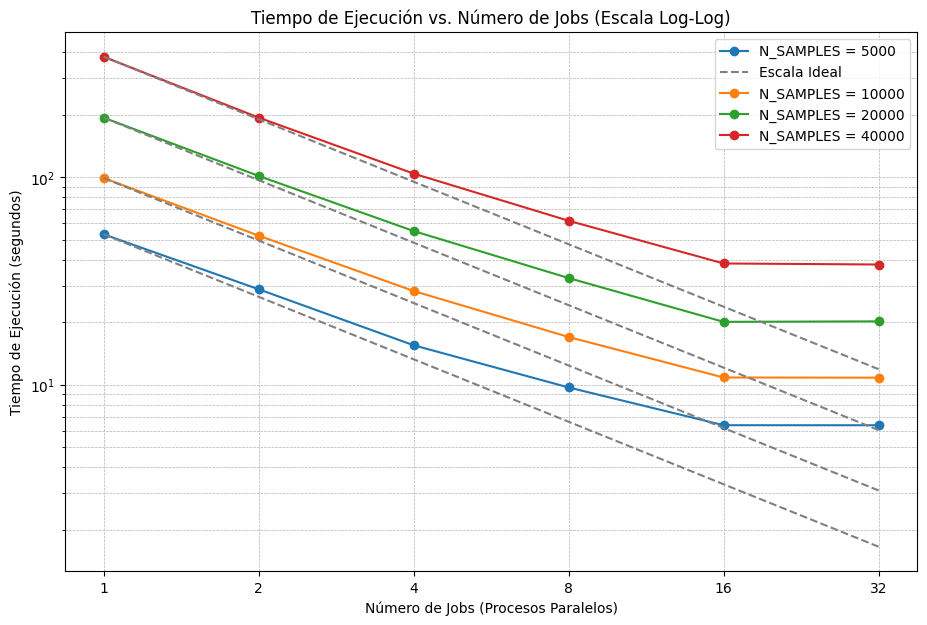

In [10]:
# Asumo que tu DataFrame final se llama 'df_resultados_measures'
# df_resultados_measures = ... (tu código de cálculo)

# --- INICIO DEL CÓDIGO PARA GRAFICAR TIEMPO DE EJECUCIÓN ---

# 1. Ordenamos los datos
df_grafico = df_resultados_measures.sort(["n_samples", "n_jobs"])

# 2. Creamos la figura y los ejes
plt.figure(figsize=(11, 7))

# 3. Obtenemos los valores únicos de n_samples
valores_n_samples = df_grafico.get_column("n_samples").unique().sort()
todos_los_n_jobs = df_grafico.get_column("n_jobs").unique().sort().to_numpy() # Convertir a array de numpy

# 4. Iteramos sobre cada valor y ploteamos su línea
for n_samp in valores_n_samples:
    subset = df_grafico.filter(pl.col("n_samples") == n_samp)

    # Ploteamos el tiempo observado
    plt.plot(
        subset.get_column("n_jobs"),
        subset.get_column("tiempo_total_entrenamiento"), # <-- CAMBIO AQUÍ
        marker='o',
        linestyle='-',
        label=f'N_SAMPLES = {n_samp}'
    )

    # Calculamos y ploteamos la "escala perfecta" para este grupo
    # Tiempo_ideal(N) = Tiempo(1) / N
    tiempo_base = subset.get_column("numerador_speedup")[0] # El tiempo con n_jobs=1
    tiempo_ideal = tiempo_base / todos_los_n_jobs

    plt.plot(
        todos_los_n_jobs,
        tiempo_ideal,
        linestyle='--',
        color='grey',
        label=f'Escala Ideal' if n_samp == valores_n_samples[0] else ""
    )

# --- ESTILIZACIÓN DE LA GRÁFICA ---

# 5. Configuramos etiquetas y título
plt.xlabel("Número de Jobs (Procesos Paralelos)")
plt.ylabel("Tiempo de Ejecución (segundos)")
plt.title("Tiempo de Ejecución vs. Número de Jobs (Escala Log-Log)")

# 6. Configuramos AMBOS ejes en escala logarítmica
plt.xscale("log", base=2)
plt.yscale("log") # <-- Eje Y también logarítmico
plt.xticks(todos_los_n_jobs, todos_los_n_jobs)

# 7. Añadimos leyenda y cuadrícula
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)

# 8. Mostramos la gráfica
plt.show()

Modelo ajustado para N=40000:
  Componente Secuencial (C_s): -4.336 s
  Componente Paralelizable (C_p): 385.411 s
  Componente de Overhead (C_o): 5.637 s


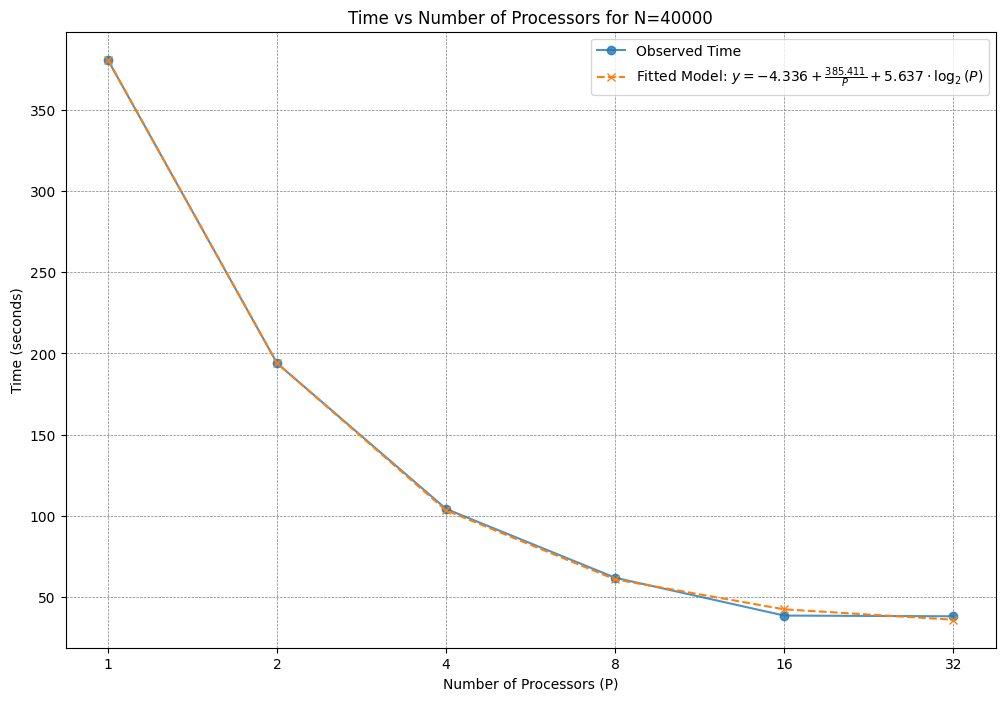

In [11]:
N_SAMPLES_TO_ANALYZE = 40000  # <--- CAMBIA ESTE VALOR (e.g., por 5000, 20000, 40000)

# Filtra el DataFrame para obtener los datos de un solo experimento
df_single_n = df_resultados_measures.filter(
    pl.col("n_samples") == N_SAMPLES_TO_ANALYZE
).sort("n_jobs")

# Si no hay datos para ese n_samples, detenemos la ejecución
if df_single_n.is_empty():
    print(f"No se encontraron datos para N_SAMPLES = {N_SAMPLES_TO_ANALYZE}. Por favor, elige otro valor.")
else:
    # 2. Extrae los datos a arrays de NumPy para usarlos con SciPy
    P = df_single_n.get_column("n_jobs").to_numpy()
    T_observed = df_single_n.get_column("tiempo_total_entrenamiento").to_numpy()

    # 3. Define la función del modelo teórico que queremos ajustar
    def theoretical_time_model(p, C_s, C_p, C_o):
        """
        Modelo de tiempo de ejecución con overhead.
        p: número de procesadores (n_jobs)
        C_s: componente de tiempo secuencial
        C_p: componente de tiempo paralelizable (para p=1)
        C_o: componente de sobrecarga (overhead)
        """
        # np.log2(1) es 0, por lo que el término de overhead desaparece para el caso base.
        return C_s + (C_p / p) + (C_o * np.log2(p))

    # 4. Usa scipy.optimize.curve_fit para encontrar los mejores parámetros
    try:
        # P_opt contendrá los valores óptimos para (C_s, C_p, C_o)
        p_opt, _ = curve_fit(theoretical_time_model, P, T_observed)
        C_s_fit, C_p_fit, C_o_fit = p_opt

        # Calcula los valores del tiempo predicho por el modelo ajustado
        T_fitted = theoretical_time_model(P, C_s_fit, C_p_fit, C_o_fit)

        print(f"Modelo ajustado para N={N_SAMPLES_TO_ANALYZE}:")
        print(f"  Componente Secuencial (C_s): {C_s_fit:.3f} s")
        print(f"  Componente Paralelizable (C_p): {C_p_fit:.3f} s")
        print(f"  Componente de Overhead (C_o): {C_o_fit:.3f} s")

        fit_successful = True
    except RuntimeError:
        print("El ajuste del modelo falló. Se graficarán solo los datos observados.")
        fit_successful = False


    # 5. Grafica los resultados
    # Para replicar el estilo oscuro del ejemplo:
    plt.style.use('default')

    plt.figure(figsize=(12, 8))

    # Plotea los datos medidos
    plt.plot(P, T_observed, marker='o', linestyle='-', label='Observed Time', alpha=0.8)

    # Si el ajuste fue exitoso, plotea el modelo
    if fit_successful:
        legend_label = (
        f'Fitted Model: $y = {C_s_fit:.3f} + \\frac{{{C_p_fit:.3f}}}{{P}} + {C_o_fit:.3f} \\cdot \\log_{{2}}(P)$'
        )
        plt.plot(P, T_fitted, marker='x', linestyle='--', label=legend_label)

    # --- ESTILIZACIÓN DE LA GRÁFICA ---
    plt.xlabel("Number of Processors (P)")
    plt.ylabel("Time (seconds)")
    plt.title(f"Time vs Number of Processors for N={N_SAMPLES_TO_ANALYZE}")

    plt.xscale("log", base=2)
    plt.xticks(P, P) # Asegura que los ticks del eje X sean 1, 2, 4, 8...

    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5, color='gray')

    plt.show()

Modelo ajustado para N=40000:
  Componente Secuencial (C_s): -5.103 s
  Componente Paralelizable (C_p): 654.787 s
  Componente de Overhead (C_o): 8.708 s


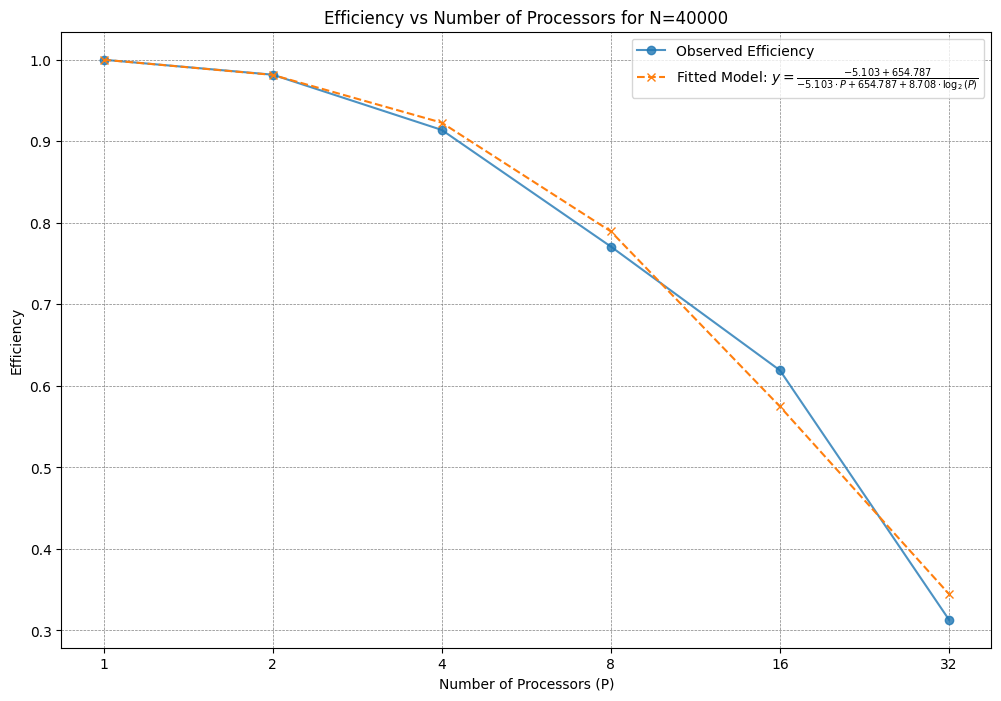

In [19]:
N_SAMPLES_TO_ANALYZE = 40000  # <--- CAMBIA ESTE VALOR (e.g., por 5000, 20000, 40000)

# Filtra el DataFrame para obtener los datos de un solo experimento
df_single_n = df_resultados_measures.filter(
    pl.col("n_samples") == N_SAMPLES_TO_ANALYZE
).sort("n_jobs")

# Si no hay datos para ese n_samples, detenemos la ejecución
if df_single_n.is_empty():
    print(f"No se encontraron datos para N_SAMPLES = {N_SAMPLES_TO_ANALYZE}. Por favor, elige otro valor.")
else:
    # 2. Extrae los datos a arrays de NumPy para usarlos con SciPy
    P = df_single_n.get_column("n_jobs").to_numpy()
    E_observed = df_single_n.get_column("efficiency").to_numpy()

    # 3. Define la función del modelo teórico que queremos ajustar
    def theoretical_efficiency_model(p, C_s, C_p, C_o):
        """
        Modelo de tiempo de ejecución con overhead.
        p: número de procesadores (n_jobs)
        C_s: componente de tiempo secuencial
        C_p: componente de tiempo paralelizable (para p=1)
        C_o: componente de sobrecarga (overhead)
        """
        # np.log2(1) es 0, por lo que el término de overhead desaparece para el caso base.
        return (C_s + C_p) / (p*C_s + C_p + p*C_o*np.log2(p))

    # 4. Usa scipy.optimize.curve_fit para encontrar los mejores parámetros
    try:
        # P_opt contendrá los valores óptimos para (C_s, C_p, C_o)
        p_opt, _ = curve_fit(theoretical_efficiency_model, P, E_observed)
        C_s_fit, C_p_fit, C_o_fit = p_opt

        # Calcula los valores del tiempo predicho por el modelo ajustado
        E_fitted = theoretical_efficiency_model(P, C_s_fit, C_p_fit, C_o_fit)

        print(f"Modelo ajustado para N={N_SAMPLES_TO_ANALYZE}:")
        print(f"  Componente Secuencial (C_s): {C_s_fit:.3f} s")
        print(f"  Componente Paralelizable (C_p): {C_p_fit:.3f} s")
        print(f"  Componente de Overhead (C_o): {C_o_fit:.3f} s")

        fit_successful = True
    except RuntimeError:
        print("El ajuste del modelo falló. Se graficarán solo los datos observados.")
        fit_successful = False


    # 5. Grafica los resultados
    # Para replicar el estilo oscuro del ejemplo:
    plt.style.use('default')

    plt.figure(figsize=(12, 8))

    # Plotea los datos medidos
    plt.plot(P, E_observed, marker='o', linestyle='-', label='Observed Efficiency', alpha=0.8)

#(C_s + C_p) / (p*C_s + C_p + p*C_o*np.log2(p))
    
    # Si el ajuste fue exitoso, plotea el modelo
    if fit_successful:
        legend_label = (
        f'Fitted Model: $y = \\frac{{{C_s_fit:.3f}+{C_p_fit:.3f}}} {{{C_s_fit:.3f}\\cdot P+  {C_p_fit:.3f}+ {C_o_fit:.3f} \\cdot \\log_{{2}}(P)}}$'
        )
        plt.plot(P, E_fitted, marker='x', linestyle='--', label=legend_label)

    # --- ESTILIZACIÓN DE LA GRÁFICA ---
    plt.xlabel("Number of Processors (P)")
    plt.ylabel("Efficiency")
    plt.title(f"Efficiency vs Number of Processors for N={N_SAMPLES_TO_ANALYZE}")

    plt.xscale("log", base=2)
    plt.xticks(P, P) # Asegura que los ticks del eje X sean 1, 2, 4, 8...

    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5, color='gray')

    plt.show()

In [1]:
base_path_ex5 = Path('logs')
file_glob_ex5 = 'rnn_rnn_joblib_ex5_*.out'
df_resultados_ex5 = procesar_y_expandir_logs(ruta_busqueda=base_path_ex5.joinpath(file_glob_ex5).as_posix())

NameError: name 'Path' is not defined